# Counter-current Heat Exchanger Models
#### Khaled Aleikish and Bernt Lie
#### University of South-Eastern Norway
#### Porsgrunn, April 2020

## Preliminaries
### Packages

In [22]:
using DifferentialEquations
using LaTeXStrings
using Plots; pyplot(); # here, pyplot is used as a back-end to the Plots API
using BenchmarkTools
using Polynomials
using LinearAlgebra

|Package|Link|
|:---|:------------|
|DifferentialEquations|https://github.com/SciML/DiffEqDocs.jl/blob/master/docs/src/index.md|
|LaTeXStrings|https://github.com/stevengj/LaTeXStrings.jl|
|Plots|https://github.com/JuliaPlots/Plots.jl|
|PyPlot|https://github.com/JuliaPy/PyPlot.jl|
|BenchmarkTools|https://github.com/JuliaCI/BenchmarkTools.jl|
|Polynomials|https://github.com/JuliaMath/Polynomials.jl/blob/master/docs/src/index.md|
|LinearAlgebra|https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/docs/src/index.md|

### Utility parameters

In [23]:
# Plot parameters
LW1 = 2.5
LW2 = 1.5
LW3 = 1
LS1 = :solid
LS2 = :dot
LS3 = :dash
LS4 = :dashdot
LA1 = 1
LA2 = 0.7
LA3 = 0.4
# File system paths
#
# Figures are stored in this path.
Figpath = "C:\\Users\\kolds\\Dropbox\\Master's_Thesis\\MSc_Report_Lyx\\fig\\Simulation_Results\\Jupyter_Notebook_1\\" 
;

### Utility functions

In [24]:
# BL Utility functions
#
# -- convert vector of samples to vector of timeseries
equal_lengths(v) = all(x->length(x)==length(first(v)), v)
#
function vec2vec(v)
    equal_lengths(v) || error("The element vectors must have equal lengths.")
    return [getindex.(v,i) for i in firstindex(v[1]):lastindex(v[1])]
end
#
;

In [25]:
# This function is used to select the proper polynomial degree
function findbestfit(y,x)
    RMSE =  Array{Float64}(undef, length(y)-1);
    for i in 1:(length(y)-1)
        p=polyfit(x, y,i)
        RMSE[i]=sqrt(sum((y-p(x)).^2) / (length(y)))
        println("Degree ", i," with RMSE: ", RMSE[i])
    end
    plot(1:(length(y)-1),RMSE,ylabel="RMSE",xlabel="Degree of Polynomial",label="RMSE",framestyle = :box,xlim=(1,(length(y)-1)),legend=:topright)
    #plot!(title="Output of the Function findbestfit for the Water Experimental Data")
end
# Example:
# findbestfit(cp_w_I,T_w_I)
# Figname = "Example_polyfit.svg"
# savefig(Figpath*Figname)
;

## Heat exchanger description
The parameters and operational data are based on the model of Åbjøra reactor in "Solution, Project, FM1015 Modelling of Dynamic Systems" by Bernt Lie. November 16, 2018.

### Thermo-physical and geometrical data

In [26]:
# Parameters
const chpa = 1.15	# Specific heat capacity of air, kJ.kg-1.K-1
const chpw = 4.2	# Specific heat capacity of water, kJ.kg-1.K-1

const hAax = 55.6	# Heat transfer, air side heat exchanger, kW/K
const hAwx = 222	# Heat transfer, water side heat exchanger, kW/K
const UAx = 1 / (1 / hAax + 1 / hAwx)	# Overall Heat transfer, heat exchanger, kW/K
#
# Heat exchanger length
# const Lx = 1.0 # x = 0 to 1 , Simpler, gives a relative position and can be omitted from the heat exchanger model.
# Because it has a value of 1, it was omitted from the model.
;

In [27]:
# BL heat capacities
function cp_a(x)
    cp_a0 = 1.007
    y = x+273.15
    y0 = 300
    return cp_a0*(299.94 + 1.008*(y-y0)+1.2e-4*(y-y0)^2+5.9e-7*(y-y0)^3+2.56e-9*(y-y0)^4)/y
end
#
function cp_w(x)
    cp_w0 = 4.179
    y = x+273.15
    y0 = 300
    return cp_w0*(0.9998-6.6e-5*(y-y0) + 6.39e-6*(y-y0)^2-1.145e-7*(y-y0)^3+8.9e-10*(y-y0)^4)
end
;

### BL fit vs. polyfit of Incropera et al

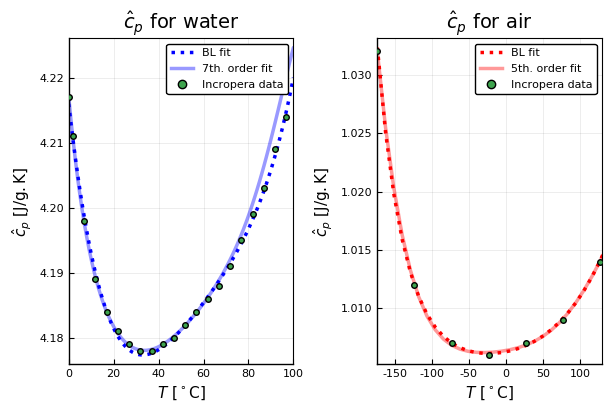

In [20]:
# Data for water and air from Incropera et al
T_w_I = [273.15, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 345.0, 350.0, 355.0, 360.0, 365.0, 370.0].-273.15
cp_w_I = [4.217,4.211,4.198,4.189,4.184,4.181,4.179,4.178,4.178,4.179,4.18 ,4.182,4.184,4.186,4.188,4.191,4.195,4.199,4.203,4.209,4.214]
T_a_I = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0].-273.15
cp_a_I = [1.032, 1.012, 1.007, 1.006, 1.007, 1.009, 1.014]
#
polynomial_w=polyfit(T_w_I,cp_w_I,7)
polynomial_a=polyfit(T_a_I,cp_a_I,5)
#
T_w = range(0,100.,length=100)
plot(T_w ,cp_w, label="BL fit",lc=:blue,lw=LW1,ls=LS2,la=LA1,xlabel=L"$T$ [$^\circ$C]",xlim=(0,100))
plot!(T_w ,polynomial_w(T_w ),label="7th. order fit",lc=:blue,lw=LW1,ls=LS1,la=LA3,ylabel=L"$\hat{c}_p$ [$\mathrm{J/g.K}$]")
fg_w = scatter!(T_w_I,cp_w_I,label="Incropera data", title=L"$\hat{c}_p$ for water")
#
T_a = range(-173.15,150,length=30)
plot(T_a,cp_a, label="BL fit",lc=:red,lw=LW1,ls=LS2,la=LA1,xlabel=L"$T$ [$^\circ$C]",xlim=(-173.15,130))
plot!(T_a,polynomial_a(T_a),label="5th. order fit",lc=:red,lw=LW1,ls=LS1,la=LA3,ylabel=L"$\hat{c}_p$ [$\mathrm{J/g.K}$]")
fg_a = scatter!(T_a_I,cp_a_I,label="Incropera data", title=L"$\hat{c}_p$ for air")
#
plot(fg_w,fg_a,framestyle = :box,legend=:topright)
#
Figname = "Specific_heat_capacity_comparison_BL_vs_polyfit.svg"
savefig(Figpath*Figname)

### NASA fit vs. polyfit of Incropera et al

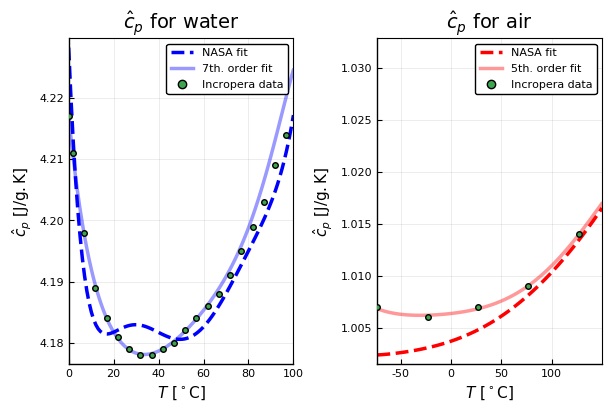

In [9]:
# H2O (L)
c_w = [1.326371304e+09, -2.448295388e+07, 1.879428776e+05, -7.678995050e+02, 1.761556813e+00, -2.151167128e-03, 1.092570813e-06]
# AIR CALCULATED FROM INGREDIENTS %N2=78.084 %O2=20.9476 %AR=0.9365 %CO2=0.0319    
c_a = [1.009950160e+04, -1.968275610e+02, 5.009155110e+00, -5.761013730e-03, 1.066859930e-05, -7.940297970e-09, 2.185231910e-12]
const Mw = 18.01528 # Molecular weight of Water, g/mol
const Ma = 28.96518 # Molecular weight of Air, g/mol ## AIR CALCULATED FROM INGREDIENTS %N2=78.084 %O2=20.9476 %AR=0.9365 %CO2=0.0319
const R = 8.31446261815324 # The Universal gas constant, J*K−1*mol−1.
#
Cp_w_nasa(x) = (R/Mw)*(c_w[1]*(x+273.15)^-2 + c_w[2]*(x+273.15)^-1 + c_w[3] + c_w[4]*(x+273.15) + c_w[5]*(x+273.15)^2 + c_w[6]*(x+273.15)^3 + c_w[7]*(x+273.15)^4) # 273.15 - 373.15 K
Cp_a_nasa(x) = (R/Ma)*(c_a[1]*(x+273.15)^-2 + c_a[2]*(x+273.15)^-1 + c_a[3] + c_a[4]*(x+273.15) + c_a[5]*(x+273.15)^2 + c_a[6]*(x+273.15)^3 + c_a[7]*(x+273.15)^4) # 200 - 1000 K
#
Tw_r = range(0,100,length=100)
plot(Tw_r,Cp_w_nasa, label="NASA fit",lc=:blue,lw=LW1,ls=LS3,la=LA1,xlabel=L"$T$ [$^\circ$C]",xlim=(0,100))
plot!(Tw_r,polynomial_w(Tw_r),label="7th. order fit",lc=:blue,lw=LW1,ls=LS1,la=LA3,ylabel=L"$\hat{c}_p$ [$\mathrm{J/g.K}$]")
fg_w = scatter!(T_w_I,cp_w_I,label="Incropera data", title=L"$\hat{c}_p$ for water")
#
Ta_r = range(-73.15,150,length=100)
plot(Ta_r,Cp_a_nasa, label="NASA fit",lc=:red,lw=LW1,ls=LS3,la=LA1,xlabel=L"$T$ [$^\circ$C]",xlim=(-73.15,150))
plot!(Ta_r,polynomial_a(Ta_r),label="5th. order fit",lc=:red,lw=LW1,ls=LS1,la=LA3,ylabel=L"$\hat{c}_p$ [$\mathrm{J/g.K}$]")
fg_a = scatter!(T_a_I,cp_a_I,label="Incropera data", title=L"$\hat{c}_p$ for air")
#
plot(fg_w,fg_a,framestyle = :box,legend=:topright)
#
Figname = "Specific_heat_capacity_comparison_NASA_vs_polyfit.svg"
savefig(Figpath*Figname)

### Operational data

In [28]:
# Inputs
Twc = 3.8	# Cold water temperature, C
Tah = 39.12	# Hot air temperature, C
mdw = 53.9	# Heat exchanger water mass flow rate, kg/s
mda = 49.2	# Heat exchanger air mass flow rate, kg/s
;

## Heat Exchanger models
### Analytic model
This model is based on Modeling of Dynamic Systems lecture notes by Bernt Lie. August 16, 2019.

In [29]:
function hex_a(inputs,par,x) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))    
    Tw(x) = ((NStw*exp(-NStd*x)-NSta)*Twc+(NStw - NStw*exp(-NStd*x))*Tac)/NStd
    Ta(x) = ((NSta*exp(-NStd*x)-NSta)*Twc+(NStw - NSta*exp(-NStd*x))*Tac)/NStd
    return [Tw(x), Ta(x)]
end
;

### Numeric boundary value model
This model solves the nonlinear two-point boundary value problem for the case of temperature dependence in the specific heat capacities of air and water.

The boundary value differential equation solver is wrapped in a function to mimic the form of `Analytic_HeatExchanger()`

`hex_n_Cp_T_dep`: The case of temperature dependence in heat capacity.

`hex_n_Cp_T_indep`: The case of temperature independence in heat capacity.

In [30]:
function hex_n_Cp_T_dep(inputs,par,x) 
    # The function for the ODE.
    function hex_i!(dy,y,par,x)
        # Interior of heat exchanger with temperature dependent heat capacity
        mdw, mda = par[3],par[4]
        UAx, cp_w, cp_a = par[5],par[6],par[7]
        #
        Tw,Ta = y
        dy[1] = -UAx/(mdw*cp_w(Tw))*(Tw - Ta)
        dy[2] = -UAx/(mda*cp_a(Ta))*(Tw - Ta)
    end
    #
    # Boundaries of heat exchanger with temperature dependent heat capacity
    function hex_b!(residual, y, par, x)
        Twc,Tah = par[1],par[2]
        residual[1] = y[1][1]-Twc	# y[1] is the beginning of the spatial span
        residual[2] = y[end][2]-Tah	# y[end] is the ending of the spatial span
    end
    #
    u0 = [0.0, 0.0] # The initial condition.
    prob_hex = BVProblem(hex_i!, hex_b!, u0, x, [inputs  par])
    sol_hex = solve(prob_hex, Shooting(Vern7()), dtmax=0.01) # Three solvers are available. Shooting is the fastest.
    return sol_hex # dtmax: Maximum dt for adaptive timestepping.
end
#
function hex_n_Cp_T_indep(inputs,par,x)
    # The function for the ODE.
    function hex_i!(dy,y,par,x)
        # Interior of heat exchanger with temperature independent heat capacity
        mdw, mda = par[3],par[4]
        UAx, cp_w, cp_a = par[5],par[6],par[7]
        #
        Tw,Ta = y
        dy[1] = -UAx/(mdw*cp_w)*(Tw - Ta)
        dy[2] = -UAx/(mda*cp_a)*(Tw - Ta)
    end
    #
    # Boundaries of heat exchanger with temperature independent heat capacity
    function hex_b!(residual, y, par, x)
        Twc,Tah = par[1],par[2]
        residual[1] = y[1][1]-Twc	# y[1] is the beginning of the spatial span
        residual[2] = y[end][2]-Tah	# y[end] is the ending of the spatial span
    end
    #
    u0 = [0.0, 0.0] # The initial condition.
    prob_hex = BVProblem(hex_i!, hex_b!, u0, x, [inputs  par])
    sol_hex = solve(prob_hex, Shooting(Vern7()), dtmax=0.01) # Three solvers are available. Shooting is the fastest.
    return sol_hex # dtmax: Maximum dt for adaptive timestepping.
end
;

In [31]:
# Parameters are passed to functions in an Array to avoid problems associated with global variables.
par_hex_a = [UAx chpw chpa]
par_hex_n_Cp_T_dep = [UAx cp_w cp_a] # Here, cp_w and cp_a are functions.
par_hex_n_Cp_T_indep = [UAx chpw chpa] # Here, chpw and chpa are constants.
#
# Inputs are passed to functions in an Array to avoid problems associated with global variables.
u_hex = [Twc Tah mdw mda]
#
# Note that both the inputs and the parameters should be passed as the same type (Array or tuple) to reduce memory allocation for the numeric solver.
#
# The spatial span for the problem.
xspan_a = collect(0:0.01:1) # step size for the analytic model is specified here.
xspan_n = (0.0, 1.0) # step size for the Numeric model depends on the method used in the solver. Shooting methods do not require a step size (dt).
;

### Solving models

In [32]:
sol_analytic = map(x -> hex_a(u_hex, par_hex_a, x), xspan_a) |> vec2vec
sol_numeric_Cp_T_dep = hex_n_Cp_T_dep(u_hex, par_hex_n_Cp_T_dep, xspan_n);
sol_numeric_Cp_T_indep = hex_n_Cp_T_indep(u_hex, par_hex_n_Cp_T_indep, xspan_n);

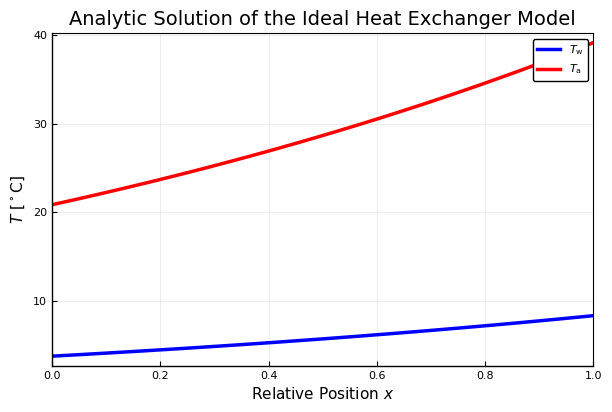

In [15]:
plot(xspan_a,sol_analytic[1],lc=:blue,lw=LW1,ls=LS1,la=LA1,label=L"$T_\mathrm{w}$")
plot!(xspan_a,sol_analytic[2],lc=:red,lw=LW1,ls=LS1,la=LA1,label=L"$T_\mathrm{a}$")
plot!(xlabel=L"Relative Position $x$",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,1))
plot!(title="Analytic Solution of the Ideal Heat Exchanger Model",framestyle = :box,legend=:topright)
Figname = "Analytic_Solution_of_the_Ideal_Heat_Exchanger_Model.svg"
savefig(Figpath*Figname)

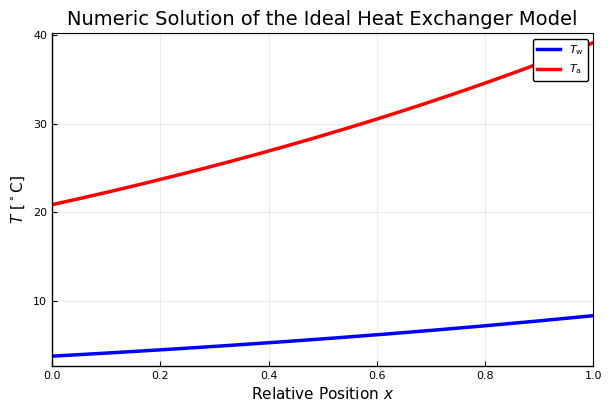

In [16]:
plot(sol_numeric_Cp_T_indep,vars=(0,1),lc=:blue,lw=LW1,ls=LS1,la=LA1,label=L"$T_\mathrm{w}$")
plot!(sol_numeric_Cp_T_indep,vars=(0,2),lc=:red,lw=LW1,ls=LS1,la=LA1,label=L"$T_\mathrm{a}$")
plot!(xlabel=L"Relative Position $x$",ylabel=L"$T$ [${}^\circ$C]")
plot!(title="Numeric Solution of the Ideal Heat Exchanger Model",framestyle = :box,legend=:topright)
Figname = "Numeric_Solution_of_the_Ideal_Heat_Exchanger_Model.svg"
savefig(Figpath*Figname)

#### Verifying that the analytic solution of the ideal heat exchanger model match the numeric solution when $\hat{c}_p$ is temperature-independent.

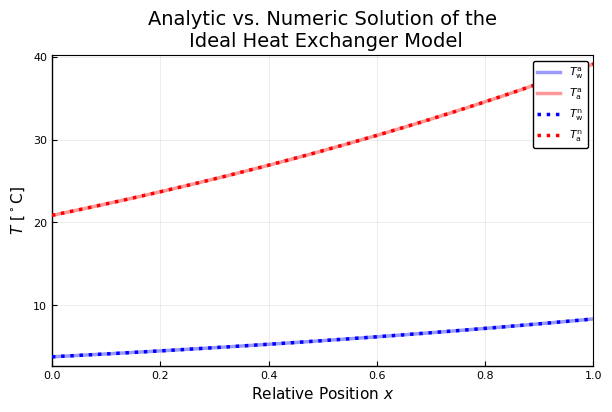

In [17]:
plot(xspan_a,sol_analytic[1],lc=:blue,lw=LW1,ls=LS1,la=LA3,label=L"$T_\mathrm{w}^\mathrm{a}$")
plot!(xspan_a,sol_analytic[2],lc=:red,lw=LW1,ls=LS1,la=LA3,label=L"$T_\mathrm{a}^\mathrm{a}$")
#
plot!(sol_numeric_Cp_T_indep,vars=(0,1),lc=:blue,lw=LW1,ls=LS2,label=L"$T_\mathrm{w}^\mathrm{n}$")
plot!(sol_numeric_Cp_T_indep,vars=(0,2),lc=:red,lw=LW1,ls=LS2,label=L"$T_\mathrm{a}^\mathrm{n}$")
plot!(xlabel=L"Relative Position $x$",ylabel=L"$T$ [${}^\circ$C]",legend=:topright)
plot!(title="Analytic vs. Numeric Solution of the\n Ideal Heat Exchanger Model",framestyle = :box)
Figname = "Analytic_Solution_vs_Numeric_Solution_of_the_ideal_heat_exchanger_model.svg"
savefig(Figpath*Figname)

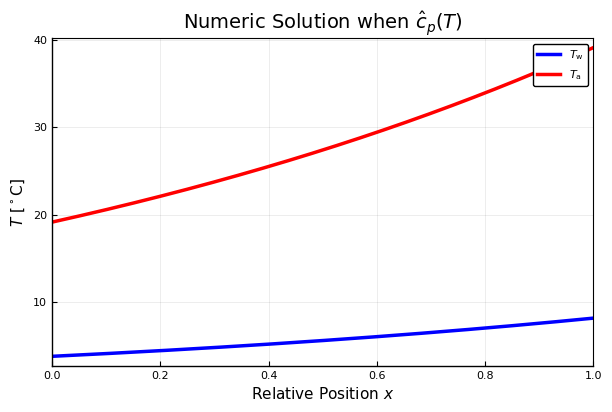

In [18]:
plot(sol_numeric_Cp_T_dep,vars=(0,1),lc=:blue,lw=LW1,ls=LS1,la=LA1,label=L"$T_\mathrm{w}$")
plot!(sol_numeric_Cp_T_dep,vars=(0,2),lc=:red,lw=LW1,ls=LS1,la=LA1,label=L"$T_\mathrm{a}$")
plot!(xlabel=L"Relative Position $x$",ylabel=L"$T$ [${}^\circ$C]",legend=:topright)
plot!(title=L"Numeric Solution when $\hat{c}_p(T)$",framestyle = :box)
Figname = "Numeric_Solution_of_the_Non-Ideal_Heat_Exchanger_Model_when_Cp(T).svg"
savefig(Figpath*Figname)

#### Comparing solutions

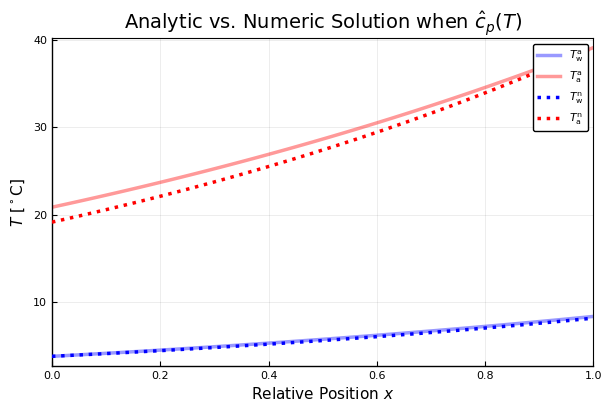

In [19]:
plot(xspan_a,sol_analytic[1],lc=:blue,lw=LW1,ls=LS1,la=LA3,label=L"$T_\mathrm{w}^\mathrm{a}$")
plot!(xspan_a,sol_analytic[2],lc=:red,lw=LW1,ls=LS1,la=LA3,label=L"$T_\mathrm{a}^\mathrm{a}$")
#
plot!(sol_numeric_Cp_T_dep,vars=(0,1),lc=:blue,lw=LW1,ls=LS2,label=L"$T_\mathrm{w}^\mathrm{n}$")
plot!(sol_numeric_Cp_T_dep,vars=(0,2),lc=:red,lw=LW1,ls=LS2,label=L"$T_\mathrm{a}^\mathrm{n}$")
plot!(xlabel=L"Relative Position $x$",ylabel=L"$T$ [${}^\circ$C]",legend=:topright)
plot!(title=L"Analytic vs. Numeric Solution when $\hat{c}_p(T)$",framestyle = :box)
Figname = "Analytic_Solution_vs_Numeric_Solution_when_Cp(T).svg"
savefig(Figpath*Figname)

#### Comparison of the execution speed of the analytic vs. Numeric Solution.

In [27]:
@benchmark sol_analytic = map(x -> hex_a($u_hex, $par_hex_a, x), $xspan_a) |> vec2vec

BenchmarkTools.Trial: 
  memory estimate:  12.30 KiB
  allocs estimate:  109
  --------------
  minimum time:     8.600 μs (0.00% GC)
  median time:      9.000 μs (0.00% GC)
  mean time:        10.630 μs (10.51% GC)
  maximum time:     2.549 ms (99.33% GC)
  --------------
  samples:          10000
  evals/sample:     3

In [28]:
@benchmark sol_numeric_Cp_T_indep = hex_n_Cp_T_indep($u_hex, $par_hex_n_Cp_T_indep, $xspan_n)

BenchmarkTools.Trial: 
  memory estimate:  5.67 MiB
  allocs estimate:  58718
  --------------
  minimum time:     3.776 ms (0.00% GC)
  median time:      3.990 ms (0.00% GC)
  mean time:        4.798 ms (12.69% GC)
  maximum time:     13.410 ms (59.68% GC)
  --------------
  samples:          1042
  evals/sample:     1

In [29]:
@benchmark sol_numeric_Cp_T_dep = hex_n_Cp_T_dep($u_hex, $par_hex_n_Cp_T_dep, $xspan_n)

BenchmarkTools.Trial: 
  memory estimate:  16.76 MiB
  allocs estimate:  740822
  --------------
  minimum time:     18.223 ms (0.00% GC)
  median time:      19.061 ms (0.00% GC)
  mean time:        20.630 ms (6.27% GC)
  maximum time:     38.420 ms (13.03% GC)
  --------------
  samples:          243
  evals/sample:     1